In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()                # convert words to their dictionary base form (e.g., "running","ran","runs" -> "run")
stop_words = set(stopwords.words("english"))    # Get the set of English stopwords to remove the noice words

def improved_clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags better
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"<[^>]+>", " ", text)
    
    # Handle contractions
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Tokenize
    words = nltk.word_tokenize(text)
    
    # Lemmatize & remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    
    # Join back
    return " ".join(words)


[nltk_data] Downloading package punkt to /home/nithish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nithish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nithish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df["clean_review"] = df["review"].apply(improved_clean_text) 
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0}) # Convert labels to binary

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_review"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]  
    #split the data in stratified manner to avoid class imbalance issues
)

### model 1: SVM with TF-IDF

In [ ]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

# Vectorize the text data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# SVM Classifier
svm = LinearSVC()
svm.fit(X_train_vec, y_train)           # train the model
y_pred_svm = svm.predict(X_test_vec)    # make predictions




SVM Results:
Accuracy: 0.8775 | Precision: 0.8702 | Recall: 0.8874 | F1: 0.8787


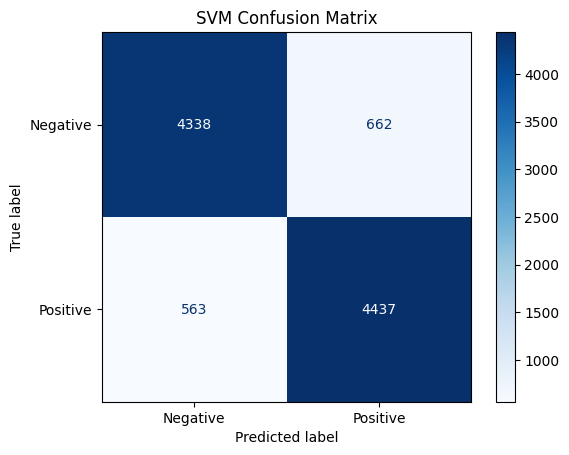

In [9]:
# Metrics
def evaluate_model(name, y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)   #  calculates Accuracy

    prec = precision_score(y_true, y_pred) # calculates Precision

    rec = recall_score(y_true, y_pred)     # calculates Recall

    f1 = f1_score(y_true, y_pred)          # calculates F1 Score

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using a blue color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Positive"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    return [acc, prec, rec, f1]

# store results
results = {}
results["SVM"] = evaluate_model("SVM", y_test, y_pred_svm)

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2025-09-24 21:19:19.742156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Tokenize & Padding
max_words = 10000 # max no. of unique words to consider
max_len = 250     # max length of each review (in words) to be exact 228

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")   # oov_token for out-of-vocabulary words
tokenizer.fit_on_texts(X_train)                                 # fit the tokenizer on the training texts

# convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

### CNN-LSTM Model

In [ ]:
model = Sequential([  # cnn-lstm model
    
    # embedding layer: maps each word index to a dense vector
    Embedding(max_words, 64, input_length=max_len),
    Dropout(0.3),  # add dropout after embedding to prevent overfitting
    
    # convolutional layer for local feature extraction
    Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),           # normalize activations for faster and stable training
    MaxPooling1D(2),                # reduce sequence length, keep important features
    Dropout(0.4),                   # again dropout after conv layer
    
    # lstm layer for capturing sequential dependencies
    LSTM(32, kernel_regularizer=regularizers.l2(0.001),  # L2 regularization on input weights
         recurrent_regularizer=regularizers.l2(0.001)),  # L2 regularization on recurrent weights

    Dropout(0.6),                # higher dropout before final layer to combat overfitting

    #final layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))
])

# compile the model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# callbacks for learning rate adjustment and early stopping

lr_scheduler = ReduceLROnPlateau(    # reduce learning rate when validation loss plateaus
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-7,
    verbose=1
)
early_stopping = EarlyStopping(      # stop training early if validation loss doesn't improve
    monitor='val_loss',  
    patience=3,
    restore_best_weights=True
)

# train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=25,
    batch_size=64,          # tried 32 and 128. 64 fits the best
    validation_split=0.25,  # Larger validation set try 2...
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/25


/home/nithish/.conda/envs/ml-gpu/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1758728964.241307   54715 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-09-24 21:19:26.147210: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4968 - loss: 0.8137 - val_accuracy: 0.5031 - val_loss: 0.7943 - learning_rate: 1.0000e-04
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5062 - loss: 0.7864 - val_accuracy: 0.5071 - val_loss: 0.7744 - learning_rate: 1.0000e-04
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5068 - loss: 0.7685 - val_accuracy: 0.5096 - val_loss: 0.7600 - learning_rate: 1.0000e-04
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5138 - loss: 0.7540 - val_accuracy: 0.5121 - val_loss: 0.7486 - learning_rate: 1.0000e-04
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5153 - loss: 0.7419 - val_accuracy: 0.5237 - val_loss: 0.7376 - learning_rate: 1.0000e-04
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5309 - loss: 0.7234 - val_accuracy: 0.5132 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7140 - lo

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN-LSTM Results:
Accuracy: 0.8811 | Precision: 0.8654 | Recall: 0.9026 | F1: 0.8836


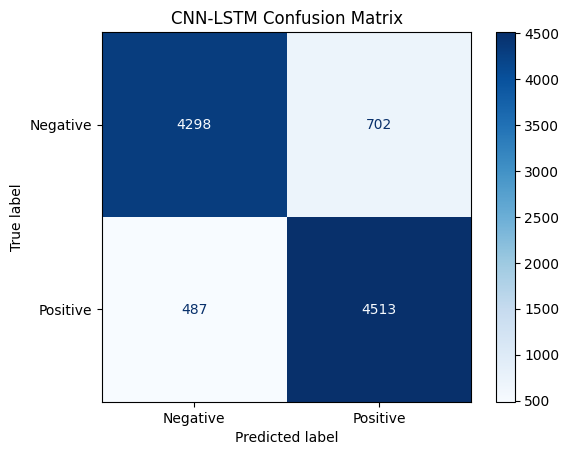

In [ ]:
# Predictions
y_pred_dl = (model.predict(X_test_pad) > 0.5).astype("int32").reshape(-1)   # threshold at 0.5 and convert 0 and 1
results["CNN_LSTM"] = evaluate_model("CNN-LSTM", y_test, y_pred_dl)         # to store the results


============== Model Comparison ===============
          Accuracy  Precision  Recall        F1
SVM         0.8775   0.870171  0.8874  0.878701
CNN_LSTM    0.8811   0.865388  0.9026  0.883603


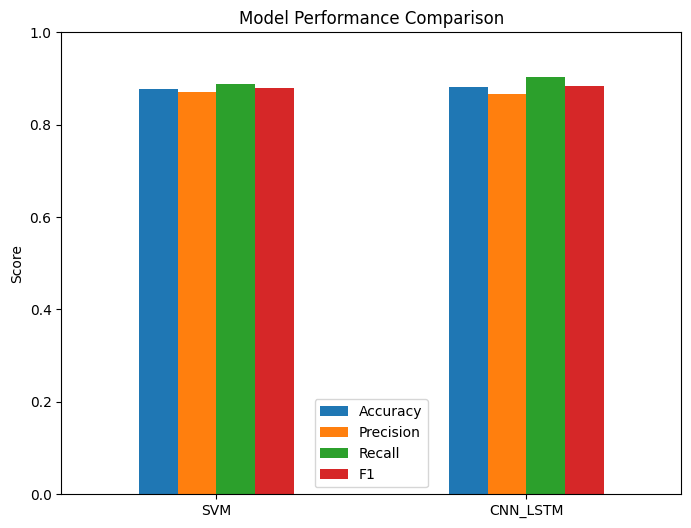

In [14]:
#Compare Results

# convert the results dictionary into a pandas DataFrame for easier comparison
results_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T  
print("\n============== Model Comparison ===============")
print(results_df)


# plot a bar chart for visual comparison
results_df.plot(kind="bar", figsize=(8,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

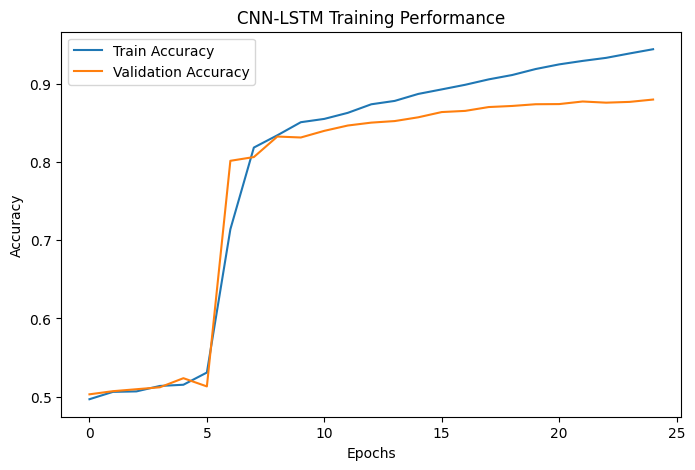

In [15]:
#Plot CNN-LSTM Training History to check for overfitting

plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("CNN-LSTM Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
import pickle


# Save trained SVM model
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm, f)

# Save TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [17]:
# Save CNN-LSTM model
model.save("cnn_lstm_model.h5")


In [18]:
# Save Tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
